In [1]:
# Install and import necessary libraries
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install split-folders

In [4]:
import splitfolders

In [5]:
direactory_org = "/content/drive/MyDrive/Tomato_leaf_diseases"
splitfolders.ratio(direactory_org,
            output="splitted_data",
            seed=42,
            ratio=(.8, .1,.1),
            group_prefix=None,
            move=False)

Copying files: 1800 files [01:52, 16.05 files/s]


In [6]:
# Set image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 128



In [7]:
# Load the dataset and split it into training (80%), validation (10%), and test (10%) sets
directory = "/content/splitted_data"
train_dataset = image_dataset_from_directory(directory+'/train',
                                       shuffle=True,
                                       labels='inferred',
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE,
                                       color_mode='rgb',
                                       seed=42)

# Splitting the validation and test sets (each 10% of the dataset)
val_dataset = image_dataset_from_directory(directory+'/val',
                                           shuffle=True,
                                           labels='inferred',
                                           batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE,
                                           color_mode='rgb',
                                           seed=42)

test_dataset = image_dataset_from_directory(directory+'/test',
                                            shuffle=True,
                                            labels='inferred',
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            color_mode='rgb',
                                            seed=43)



Found 1437 files belonging to 6 classes.
Found 178 files belonging to 6 classes.
Found 185 files belonging to 6 classes.


In [8]:
class_names = train_dataset.class_names
class_names



['_tomato_bacterial_wilt',
 '_tomato_blight_leaf',
 '_tomato_brown_spots',
 '_tomato_healthy',
 '_tomato_leaf_mosaic_virus',
 '_tomato_leaf_yellow_virus']

In [9]:
output_class = len(class_names)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
IMG_SHAPE = IMG_SIZE +(3,)
 #base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
#base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
# base_model = tf.keras.applications.InceptionV3(
#     include_top=False,
#     weights="imagenet",
#     input_shape=IMG_SHAPE,
#     pooling='max'
# )
base_model = tf.keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    pooling='max'
)

234545216/234545216 [==============================] - 11s 0us/step


In [29]:
type(base_model)
preprocess_input = tf.keras.applications.resnet_rs.preprocess_input # Removed extra space before this line
#preprocess_input = tf.keras.applications.Inception.preprocess_input

In [30]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)

Numbers of Layers = 565
post_relu
max_pool


In [31]:
def plant_leaf_model( image_shape=IMG_SIZE):

    image_shape = image_shape + (3,)

    ResNet152V2_model = tf.keras.applications.ResNet152V2(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
    ResNet152V2_model.trainable = True
    for layer in ResNet152V2_model.layers[0 : 291]:
        layer.trainable = False

    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = ResNet152V2_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(6 ,activation = "softmax")
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

In [32]:
# Print model summary
Plant_Leaf_Model = plant_leaf_model(IMG_SIZE)



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 58343942 (222.56 MB)
Trainable params: 39319046 (149.99 MB)
Non-trainable params: 19024896 (72.57 MB)
_________

In [33]:
base_learning_rate = 0.001
Plant_Leaf_Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [34]:
start_time = time.time()
history = Plant_Leaf_Model.fit(train_dataset , verbose=1 , epochs=30 , validation_data=val_dataset , use_multiprocessing= True)
end_time = time.time()


Epoch 1/30
12/12 [==============================] - 140s 2s/step - loss: 640.8102 - accuracy: 0.2756 - val_loss: 12.2526 - val_accuracy: 0.5506
Epoch 2/30
12/12 [==============================] - 73s 3s/step - loss: 14.5380 - accuracy: 0.3424 - val_loss: 3.8386 - val_accuracy: 0.5337
Epoch 3/30
12/12 [==============================] - 72s 3s/step - loss: 2.3948 - accuracy: 0.4217 - val_loss: 0.9378 - val_accuracy: 0.6180
Epoch 4/30
12/12 [==============================] - 68s 3s/step - loss: 0.8933 - accuracy: 0.6903 - val_loss: 0.7728 - val_accuracy: 0.6910
Epoch 5/30
12/12 [==============================] - 72s 3s/step - loss: 0.9188 - accuracy: 0.6639 - val_loss: 0.6736 - val_accuracy: 0.6742
Epoch 6/30
12/12 [==============================] - 71s 3s/step - loss: 0.7469 - accuracy: 0.7119 - val_loss: 0.6604 - val_accuracy: 0.7303
Epoch 7/30
12/12 [==============================] - 71s 3s/step - loss: 0.6050 - accuracy: 0.7724 - val_loss: 0.5576 - val_accuracy: 0.7191
Epoch 8/30
12/1

In [35]:
# Time taken to train the model
time_taken_seconds  = (end_time - start_time)
# Convert to hours, minutes, and seconds
hours = int(time_taken_seconds // 3600)
minutes = int((time_taken_seconds % 3600) // 60)
seconds = int(time_taken_seconds % 60)

print(f"Time taken to train the model: {hours} hours, {minutes} minutes, {seconds} seconds")

Time taken to train the model: 0 hours, 38 minutes, 18 seconds


In [36]:
# Evaluate the model on the test set
test_loss, test_accuracy = Plant_Leaf_Model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



2/2 [==============================] - 6s 378ms/step - loss: 0.6127 - accuracy: 0.7622
Test Loss: 0.6127
Test Accuracy: 0.7622


In [37]:
Plant_Leaf_Model.evaluate(val_dataset , verbose = 1)

2/2 [==============================] - 8s 325ms/step - loss: 0.5433 - accuracy: 0.8090


[0.5432709455490112, 0.8089887499809265]

In [38]:
model_name = 'resnet'

# Save the model weights in H5 format with the model name
base_model.save_weights(f'/content/drive/MyDrive/weightsave/resnet/{model_name}_weights.h5')

# Save the entire model in H5 format with the model name
base_model.save(f'/content/drive/MyDrive/weightsave/resnet/{model_name}.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step


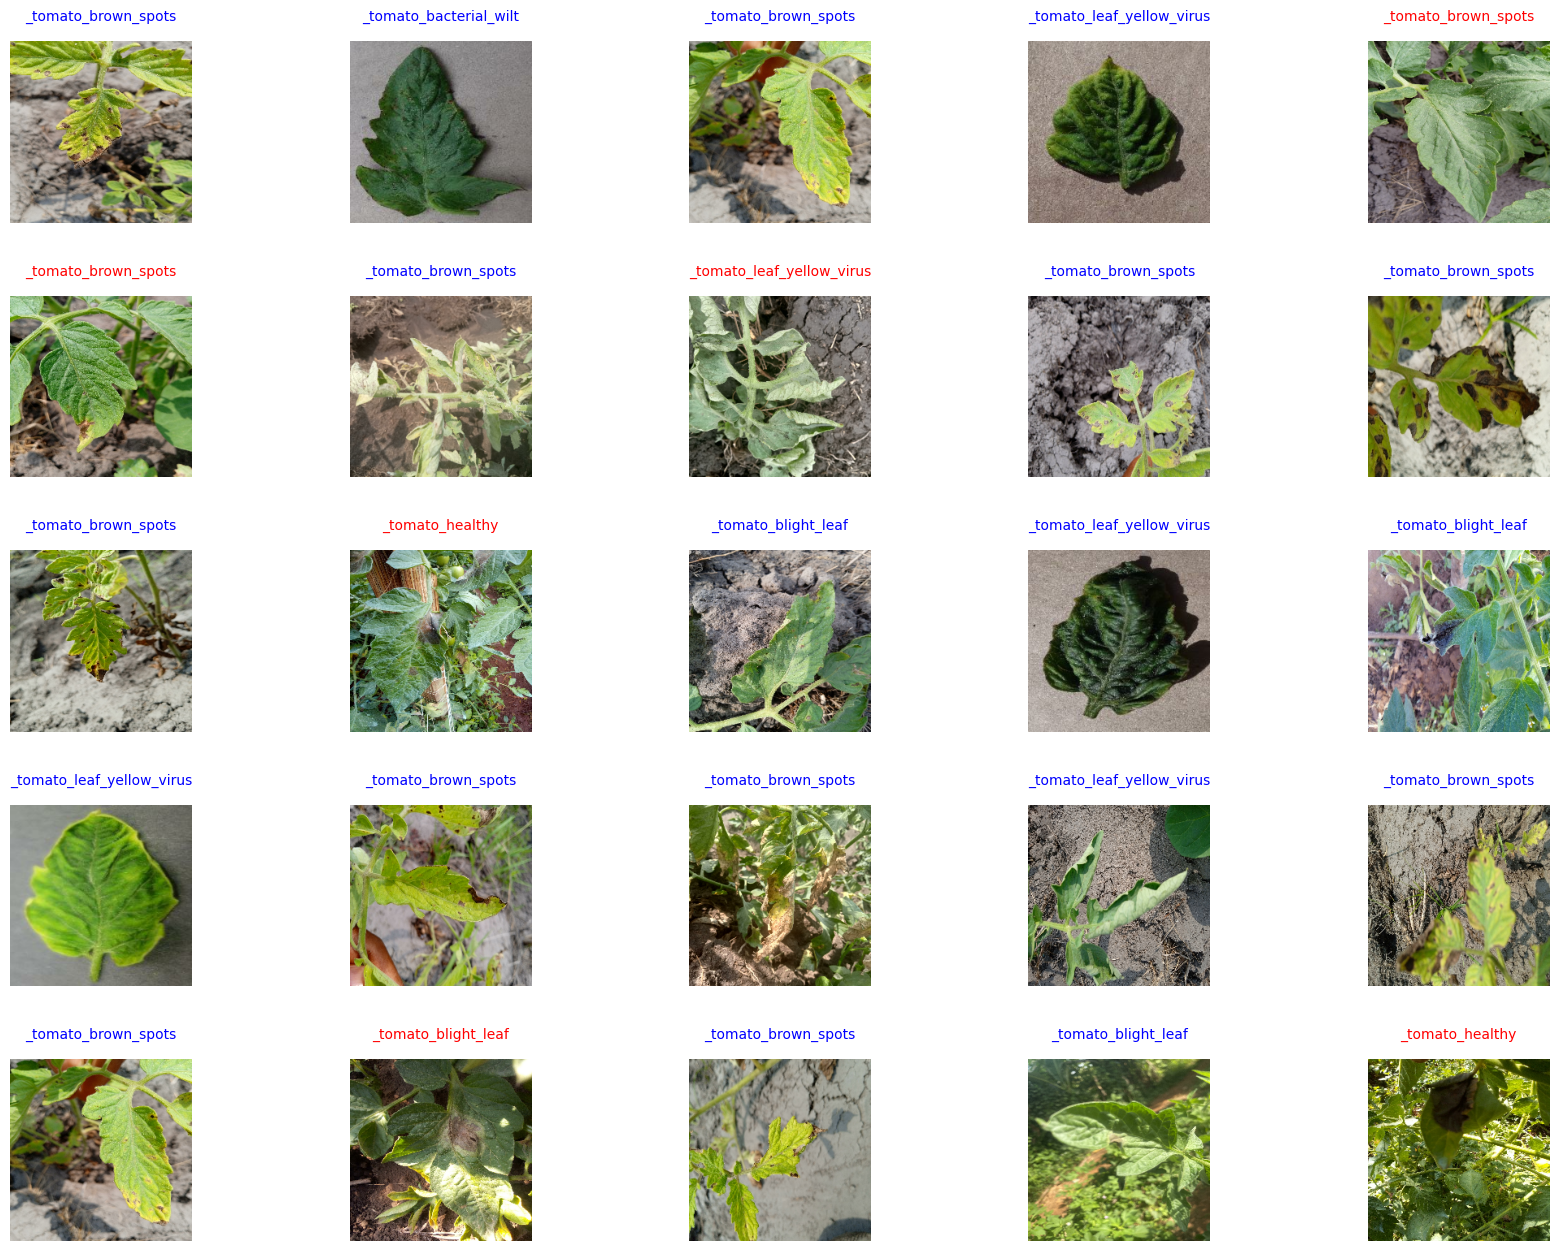

In [39]:
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = Plant_Leaf_Model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)

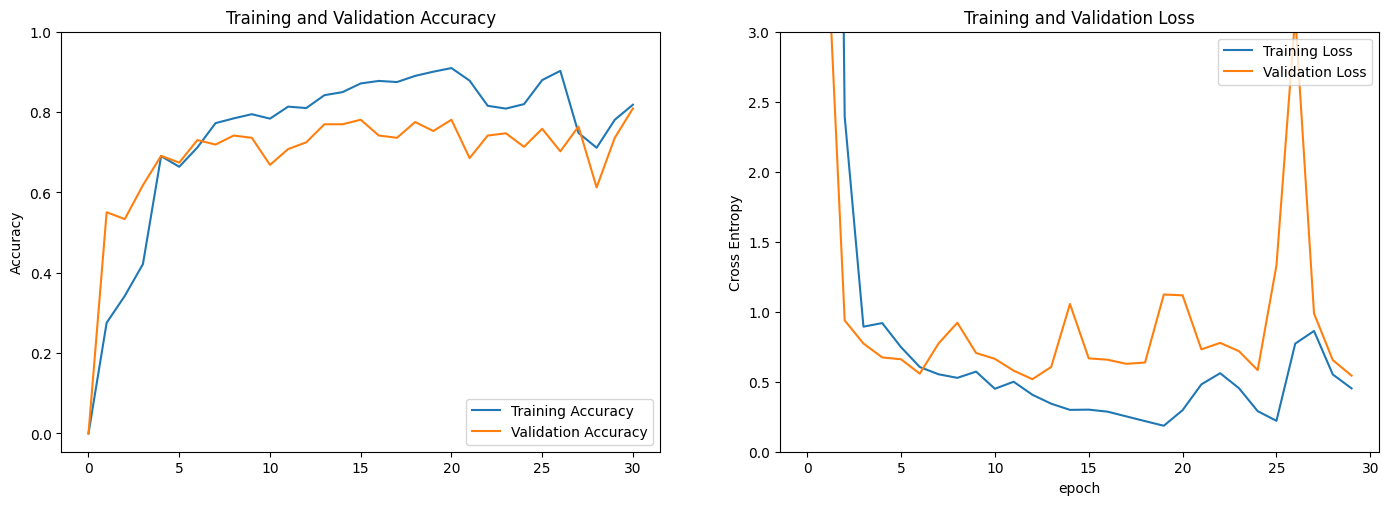

In [40]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
# Number of input nodes
num_input_nodes = np.prod(IMG_SIZE) * 3  # IMG_SIZE (height, width) * 3 (RGB channels)
print(f'Number of input nodes: {num_input_nodes}')


Number of input nodes: 150528


Text(0.5, 1.0, 'Training and Validation Accuracy')

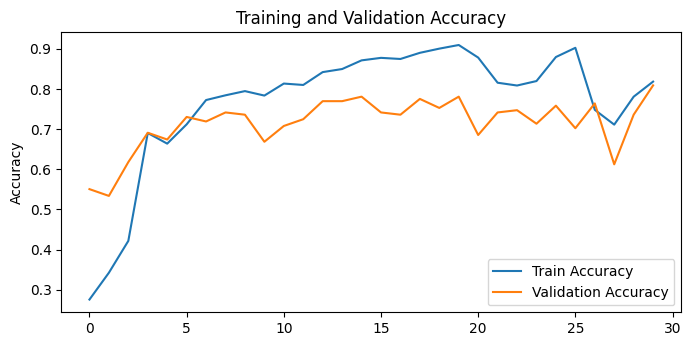

In [42]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')



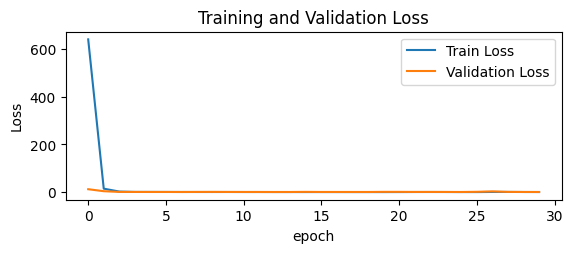

In [43]:
# Plot training & validation loss values
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()